In [1]:
import pandas as pd
import glob, os, ast, re
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/가사(결측치 제거)/"
files = glob.glob(os.path.join(DATA_PATH, "*.xlsx"))

dfs = [pd.read_excel(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df.columns
# ['Year','Month','Rank','Title','Artist','Album','Song_ID','Lyrics']

Index(['Year', 'Month', 'Rank', 'Title', 'Artist', 'Album', 'Song_ID',
       'Lyrics'],
      dtype='object')

In [3]:
Lyrics = "Lyrics"

def ensure_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("[") and x.endswith("]"):
            try:
                return ast.literal_eval(x)
            except:
                pass
        return x.split()
    return []

df[Lyrics] = df[Lyrics].apply(ensure_list)
long_df = df[['Year','Song_ID',Lyrics]].explode(Lyrics)
long_df = long_df.dropna(subset=[Lyrics])
long_df = long_df[long_df[Lyrics] != ""]

In [4]:
def make_period(y):
    y = int(y)
    if y == 1996: return "Pre-IMF"
    if 1997 <= y <= 2001: return "IMF"
    if y == 2002: return "WorldCup"
    if 2003 <= y <= 2007: return "Recovery"
    if 2008 <= y <= 2009: return "FinCrisis"
    if 2010 <= y <= 2015: return "LowGrowth"
    if 2016 <= y <= 2019: return "Platform/N포"
    if 2020 <= y <= 2022: return "COVID"
    if 2023 <= y <= 2025: return "HighInflation"
    return "Other"

long_df['Period'] = long_df['Year'].apply(make_period)

def normalize_token(t):
    t = str(t)
    t = re.sub(r'[^가-힣a-zA-Z0-9]', '', t)
    return t.lower()

long_df['tok_norm'] = long_df[Lyrics].apply(normalize_token)

In [5]:
SEED_GROUPS = {
    "imagery": ['꿈','별','달','밤','빛','하늘','dream','light'],
    "imf": ['imf','위기','경제','실업','돈','crisis','economy'],
    "work": ['회사','직장','출근','퇴근','일','job','work'],
    "life": ['집','혼자','방','자취','home','alone'],
    "covid_grp": ['마스크','비대면','온라인','zoom','quarantine'],
    "inflation": ['물가','월세','금리','대출','inflation','rent'],
    "worldcup": ['월드컵','승리','응원','태극','victory','win']
}

GROUP_SETS = {
    k: set(normalize_token(w) for w in v)
    for k, v in SEED_GROUPS.items()
}
for gname, gset in GROUP_SETS.items():
    long_df[gname] = long_df['tok_norm'].apply(
        lambda t: 1 if t in gset else 0
    )


In [6]:
group_cols = list(GROUP_SETS.keys())

song_event_year = (
    long_df
    .groupby(['Year','Song_ID'])[group_cols]
    .sum()
    .reset_index()
)

for g in group_cols:
    song_event_year[g] = (song_event_year[g] > 0).astype(int)
year_penetration = (
    song_event_year
    .groupby('Year')[group_cols]
    .mean()
    .reset_index()
)

year_penetration.head()
year_df = year_penetration.sort_values('Year')

for g in group_cols:
    year_df[g+'_smoothed'] = year_df[g].rolling(
        window=3, center=True
    ).mean()


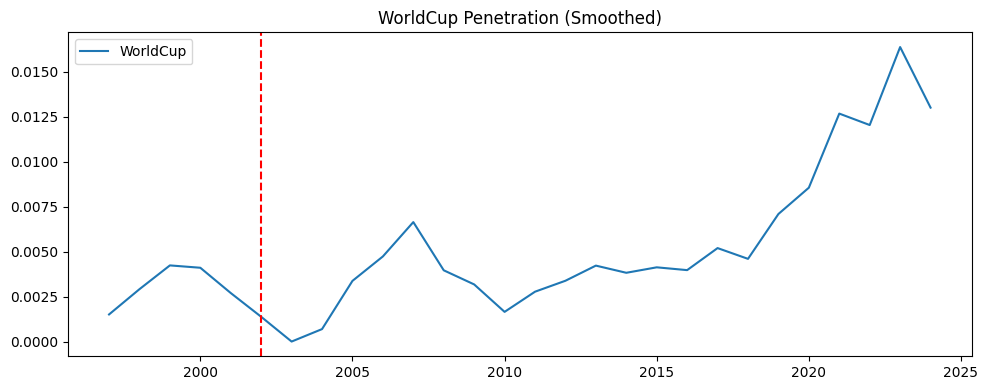

In [7]:
plt.figure(figsize=(10,4))
plt.plot(year_df['Year'], year_df['worldcup_smoothed'], label='WorldCup')
plt.axvline(2002, linestyle='--', color='red')
plt.title("WorldCup Penetration (Smoothed)")
plt.legend()
plt.tight_layout()
plt.show()


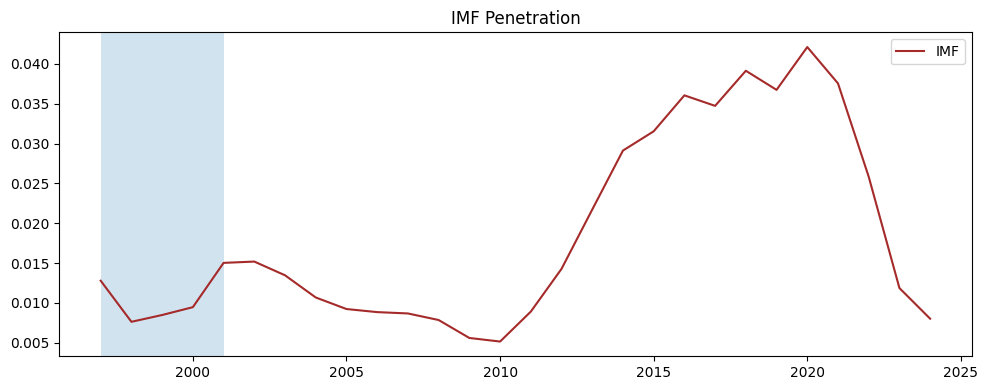

In [8]:
plt.figure(figsize=(10,4))
plt.plot(year_df['Year'], year_df['imf_smoothed'], label='IMF', color='brown')
plt.axvspan(1997, 2001, alpha=0.2)
plt.title("IMF Penetration")
plt.legend()
plt.tight_layout()
plt.show()


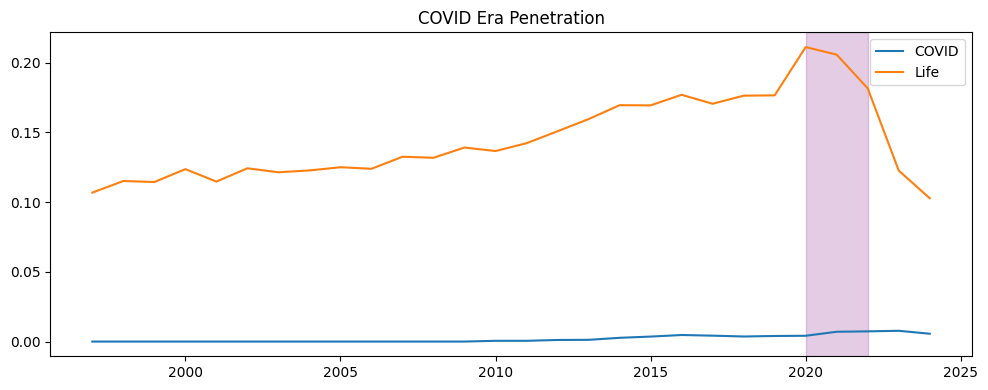

In [9]:
plt.figure(figsize=(10,4))
plt.plot(year_df['Year'], year_df['covid_grp_smoothed'], label='COVID')
plt.plot(year_df['Year'], year_df['life_smoothed'], label='Life')
plt.axvspan(2020, 2022, alpha=0.2, color='purple')
plt.legend()
plt.title("COVID Era Penetration")
plt.tight_layout()
plt.show()
